# This notebook provides brief examples on how to use the matched multifilter (MMF) and constrained matched multifilter (CMMF) functions that are provided in the flat-sky approximation as part of the PyMF module. The latter is a new extension of the matched multifilter concept that is introduced in Erler et al. (2018) (arXiv:1809.06446). In this notebook we use simulations of the thermal Sunyaev-Zeldovich effect signal and Planck HFI data. 

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from astropy.io import fits
from ipywidgets import FloatProgress
from IPython.display import display

h = 6.626070040e-34 #Planck constant (J*s)
k_B = 1.38064852e-23 #Botzmann constant (J/K)
T_CMB = 2.7255 #CMB monopole temperature (K)

In [2]:
#Import pyMF
import pymf as mf

In this notebook we use mock thermal Sunyaev-Zeldovich effect maps and real Planck HFI foreground maps (100 GHz - 857 GHz) to demonstrate the application of the matched multifilter and constrained matched multifilter. Galaxy clusters are simulated using a projected $\beta$-model (Cavaliere & Fusco-Femiano 1976). The default model parameters are a core radius $r_c = 12$ arcmin, $\beta=1$ and a central Comptonization parameter $y_0=10^{-4}$. The simulated maps have a size of 10° by 10° and a pixel size of 1.5 arcmin, both of which are fixed by the provided CMB mock data. The resolution of the maps varies with frequency from 9.68 arcmin at 100 GHz to 4.64 arcmin at 857 GHz. As with the single-frequency matched filter, we encourage the user to expore different values of $r_c$, $y_0$, and map noise to develop an understanding how these parameters affect the matched multifilters. Throughout this notebook we use units of $K_\mathrm{CMB}$.

In [3]:
#Define properties of the mock data
freq = np.array([100,143,217,353,545,857])*1e9
fwhm_arcmin =  np.array([9.68,7.30,5.02,4.94,4.83,4.64]) #arcmin
sigma_noise = np.array([77.3,33.4,46.5,156,806,1.92e4])*1e-6 #noise level (K-arcmin) (reference only)
nf = len(freq) #number of channels

#Define cluster model properties
y_0 = 1e-4 #Central Comptonization parameter (model  amplitude)
r_c = 12 #Core radius
beta = 1

#Load Planck HFI foregrounds (5 random fields) and define map dimensions
#The map size and pixel size are determined by the CMB mock data and should not be changed.

hdulist=fits.open("example_maps/Planck_foregrounds.fits")
foregrounds = hdulist[0].data
hdulist.close()
n_maps = foregrounds.shape[0] #number of maps

pixel_size = 1.5 #arcmin/pixel
map_size = 10 #degrees
npix = int(map_size*60 / pixel_size) 

# create cluster model (using beta-model)

YY, XX = np.indices((npix, npix))
center = (npix//2,npix//2)
r = np.sqrt((XX-center[0])**2 + (YY-center[1])**2)*pixel_size

cluster = y_0 * (1+(r/r_c)**2)**((1-3*beta)/2)

#create source templates (cluster template normalized to unity and smoothed with beams)
template = cluster/y_0

sigma_beam = fwhm_arcmin / (2*np.sqrt(2*np.log(2))) / pixel_size

source = np.zeros((nf,npix,npix)) #note the dimensions
for i in np.arange(nf):
    source[i,:,:] = gaussian_filter(template, sigma=sigma_beam[i], order=0, mode='wrap', truncate=20.0)

#Compute tSZ spectrum

x = h*freq / k_B / T_CMB
spec = (x*(np.exp(x)+1)/(np.exp(x)-1) - 4)*T_CMB

#create point source templates for CMMF examples
A_point = 1e-4
point_source = np.zeros((nf,npix,npix)) #note the dimensions
for i in np.arange(nf):
    point_source[i,:,:] = np.exp(-0.5*(r/(sigma_beam[i]*pixel_size))**2)

#Perseus A SED from Erler et al. 2018 converted to K_CMB
ps_sed = np.array([0.00472591,  0.00233703,  0.00132194,  0.00159489,  0.00540143, 0.10411034])

In the next step, we combine the simulated cluster with the Planck foregrounds. The data is then filtered with a matched multifilter

$\Psi(k) = \sigma^2_\mathrm{MMF} P^{-1}(k) F(k)$,

with

$ \sigma^2_\mathrm{MMF} = \left[\int \mathrm{d}^2k \ F^\mathrm{T}(k) P^{-1}(k) F(k) \right]^{-1}$

and

$F(k) = f(\nu) * \tau(k)$,

where $F$ is the Fourier transform of the multi-frequency source template that was convolved with the beam and $P$ is the cross spectrum of the $n_\nu$ maps. The function mf.filter_map_mmf() requires three inputs, the first being a data cube containing the (mock) observations, the second is a data cube of the convolved source template $(\tau(\nu)$, where $\nu$ signifies a dependence of the beam on the frequency) and the last input is the SED of the source $f(\nu)$. In its default mode, the function will compute the cross power spectrum directly from the provided data, however optional variables allows to provide either a separate noise maps or the standard deviation of the noise in case it is Gaussian. It is also possible to use a single, global frequency to frequency correlation matrix for the computation of the cross spectrum or ignore the cross-terms entirely. A global correlation matrix is computed from the full maps (default is a different correlation matrix at each k) and will be used in the examples presented here. The advantage of this approach is its robustness against variance in the correlation between channels that is introduced by noise and can lead to a minor bias. On the contrary, using a global correlation matrix will yield a slightly lower SNR than the optimal (default) approach. The filter function returns three variables, the filtered map, the 2D filter window, and the noise of the filtered map $\sigma_\mathrm{MMF}$.

In [4]:
data = np.zeros((nf,npix,npix)) #note the dimensions
for i in np.arange(nf):
    #convolve mock data with beam
    data[i,:,:] = gaussian_filter(spec[i]*cluster, sigma=sigma_beam[i], order=0, mode='wrap', truncate=20.0)
    #add Planck HFI foregrounds
    data[i,:,:] += foregrounds[0,i,:,:]
    #subtract mean of the maps
    data[i,:,:] -= np.mean(data[i,:,:])

#filter data with matched filter
mmf_map, mmf_filter, mmf_noise = mf.filter_map_mmf(data, source, spec, global_cross=True)

/home/jens/Software/anaconda3/lib/python3.7/site-packages/pymf-1.1-py3.7.egg/pymf/pymf.py:168: ComplexWarning: Casting complex values to real discards the imaginary part
  power[i,:] = make_filter_map(images[0,:,:], k, Pk).reshape(npix)


The central deconvolved Comptonization parameter $y_0$ is then given by the map value at the position of the center of the cluster.

In [5]:
print("y_0: ", '{:0.2e}'.format(mmf_map[center]))
print("noise: ", '{:0.2e}'.format(mmf_noise))
print("SNR: ", '{:0.2f}'.format(mmf_map[center]/mmf_noise))
print("bias: ", '{:0.2f}'.format((mmf_map[center]-1e-4)/mmf_noise), "sigma")

y_0:  1.02e-04
noise:  4.42e-06
SNR:  23.14
bias:  0.51 sigma


The plots below show the mock data and the filtered map.

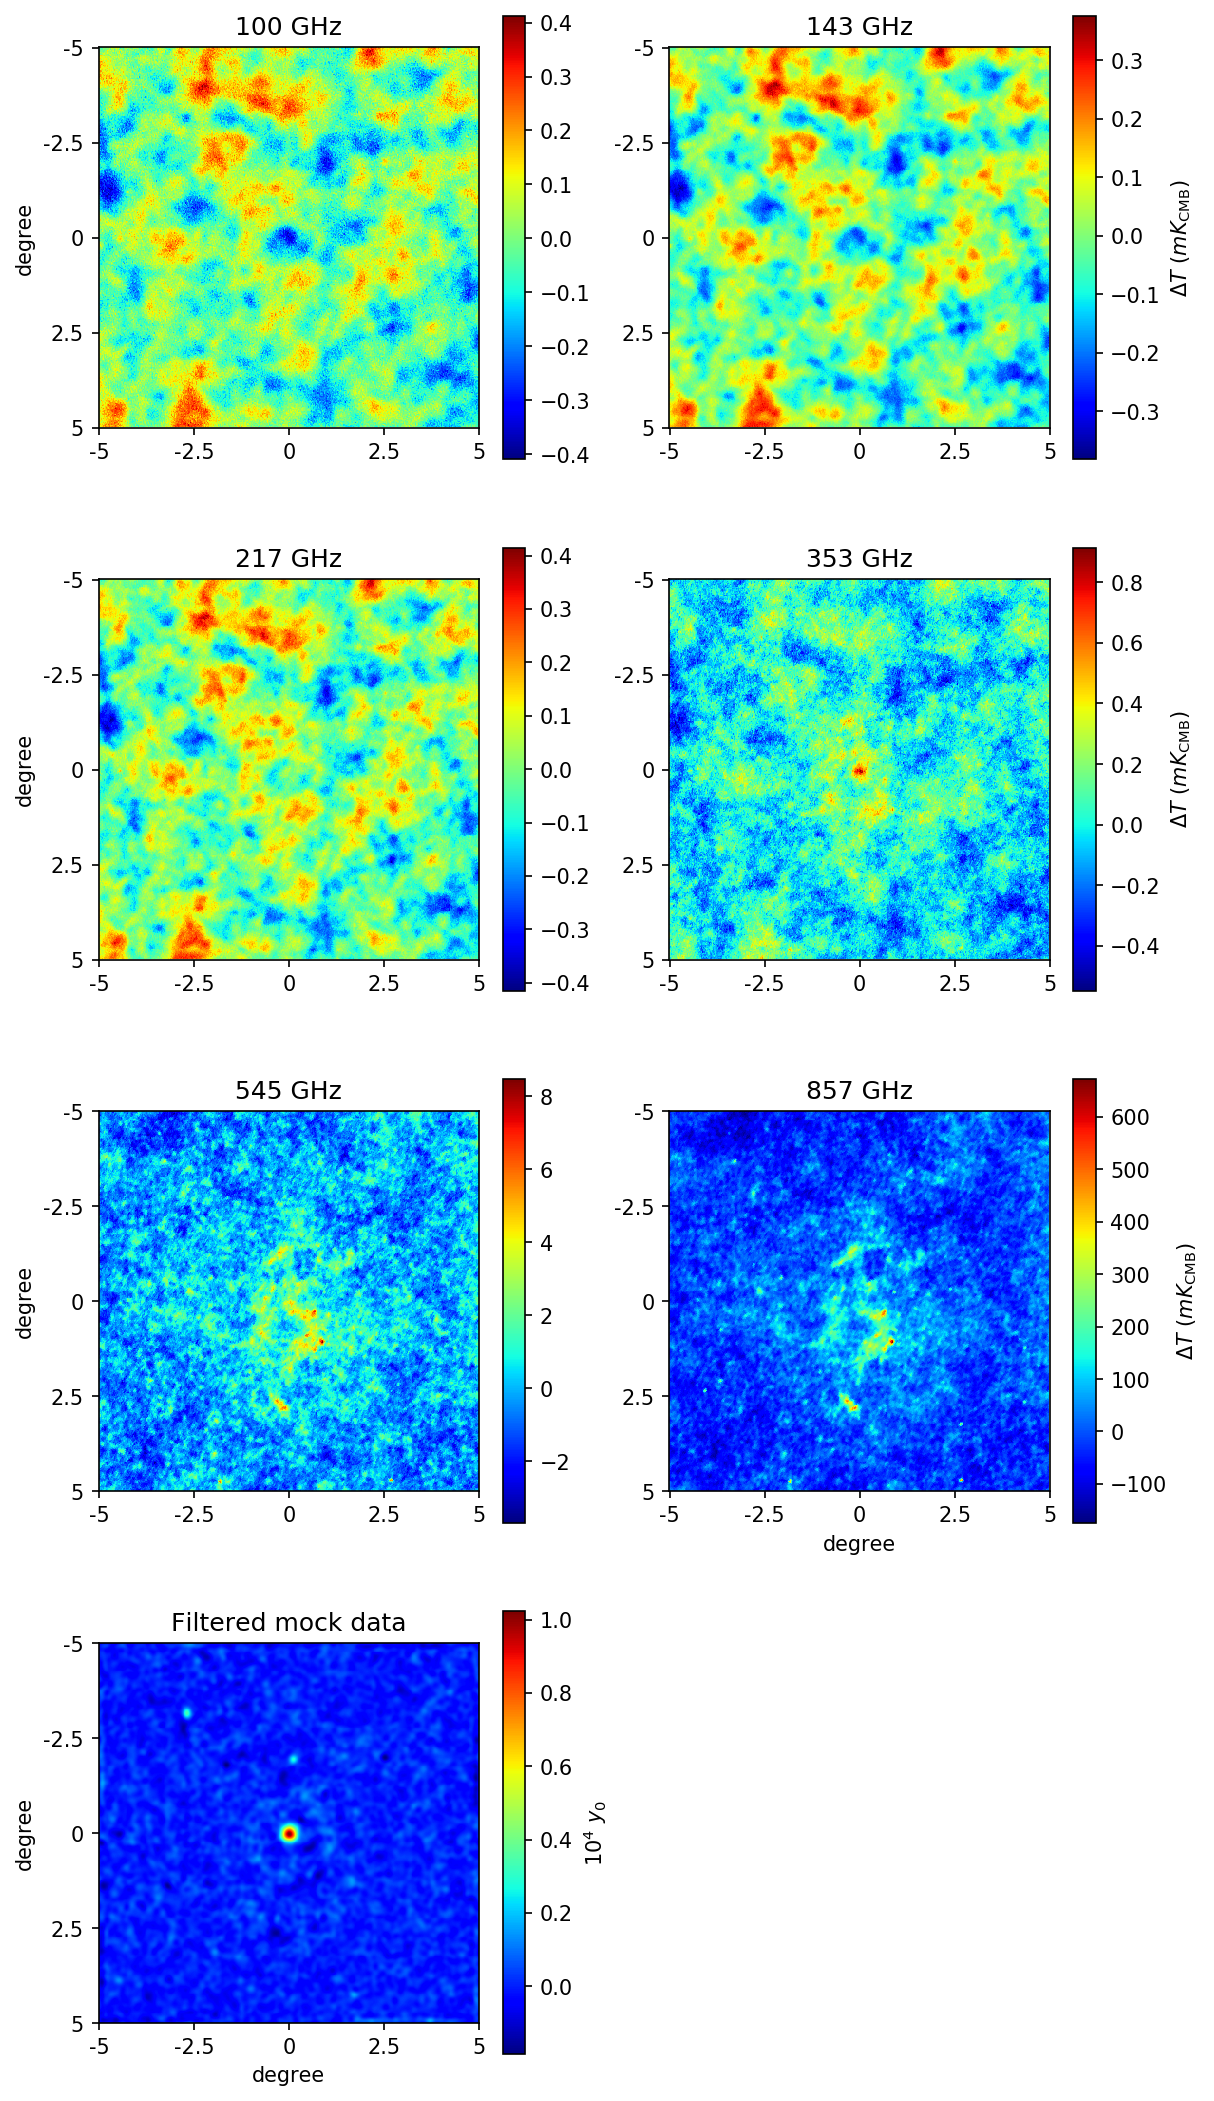

In [6]:
fig = plt.figure(figsize=(9,18), dpi=150)

plt.subplot(4,2,1)
plt.imshow(1e3*data[0,:,:], cmap = "jet")
plt.title("100 GHz")
plt.ylabel("degree")
plt.xticks([0,100,200,300,400],[-5,-2.5,0,2.5,5])
plt.yticks([0,100,200,300,400],[-5,-2.5,0,2.5,5])
plt.colorbar()

plt.subplot(4,2,2)
plt.imshow(1e3*data[1,:,:], cmap = "jet")
plt.title("143 GHz")
plt.xticks([0,100,200,300,400],[-5,-2.5,0,2.5,5])
plt.yticks([0,100,200,300,400],[-5,-2.5,0,2.5,5])
plt.colorbar(label = r"$\Delta T$ ($m K_\mathrm{CMB}$)")

plt.subplot(4,2,3)
plt.imshow(1e3*data[2,:,:], cmap = "jet")
plt.title("217 GHz")
plt.ylabel("degree")
plt.xticks([0,100,200,300,400],[-5,-2.5,0,2.5,5])
plt.yticks([0,100,200,300,400],[-5,-2.5,0,2.5,5])
plt.colorbar()

plt.subplot(4,2,4)
plt.imshow(1e3*data[3,:,:], cmap = "jet")
plt.title("353 GHz")
plt.xticks([0,100,200,300,400],[-5,-2.5,0,2.5,5])
plt.yticks([0,100,200,300,400],[-5,-2.5,0,2.5,5])
plt.colorbar(label = r"$\Delta T$ ($m K_\mathrm{CMB}$)")

plt.subplot(4,2,5)
plt.imshow(1e3*data[4,:,:], cmap = "jet")
plt.title("545 GHz")
plt.ylabel("degree")
plt.xticks([0,100,200,300,400],[-5,-2.5,0,2.5,5])
plt.yticks([0,100,200,300,400],[-5,-2.5,0,2.5,5])
plt.colorbar()

plt.subplot(4,2,6)
plt.imshow(1e3*data[5,:,:], cmap = "jet")
plt.title("857 GHz")
plt.xlabel("degree")
plt.xticks([0,100,200,300,400],[-5,-2.5,0,2.5,5])
plt.yticks([0,100,200,300,400],[-5,-2.5,0,2.5,5])
plt.colorbar(label = r"$\Delta T$ ($m K_\mathrm{CMB}$)")

plt.subplot(4,2,7)

plt.imshow(1e4*mmf_map, cmap = "jet")
plt.title("Filtered mock data")
plt.xlabel("degree")
plt.ylabel("degree")
plt.xticks([0,100,200,300,400],[-5,-2.5,0,2.5,5])
plt.yticks([0,100,200,300,400],[-5,-2.5,0,2.5,5])
plt.colorbar(label = r"$10^4 \ y_0$")

The next figures show the 1D profiles of the filter windows and filter kernels. The frequency can be changed by changing the value of $i$.

/home/jens/Software/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


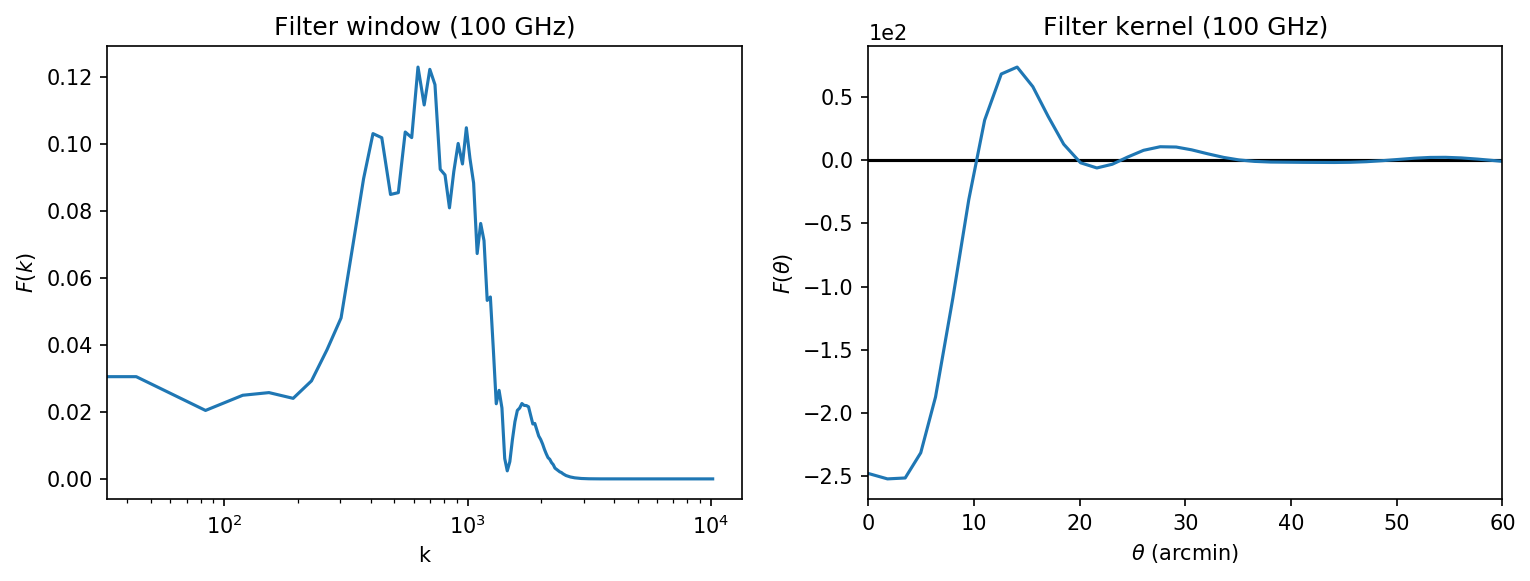

In [7]:
#Compute filter kernel through Fourier transform of the filter window
mmf_kernel = np.zeros((nf,npix,npix))
for i in np.arange(nf):
    mmf_kernel[i,:,:] = np.real(np.fft.ifft2(np.fft.ifftshift(mmf_filter[i,:,:]))) * npix**2

i = 0 #change to plot different frequencies    
    
#Compute radial profiles of window and kernel. 
#The spatial frequency k has been computed using a conversion that allows a direct 
#comparison with the spherical multipole moment ell.
k, window = mf.rad_profile(np.abs(mmf_filter[i,:,:]), pixel_size, return_k=True)
theta, kernel = mf.rad_profile(mmf_kernel[i,:,:], pixel_size, return_k=False)

fig = plt.figure(figsize=(12,4), dpi=150)

plt.subplot(1,2,1)
plt.semilogx(k, window)
#plt.xlim(1e2,4e4)
plt.title("Filter window (" + str(int(freq[i]/1e9)) + " GHz)")
plt.xlabel(r"k")
plt.ylabel(r"$F(k)$")

plt.subplot(1,2,2)
plt.plot([0,170],[0,0], '-', color="black")
plt.plot(theta*pixel_size, kernel)
plt.xlim(0,60)
plt.title("Filter kernel (" + str(int(freq[i]/1e9)) + " GHz)")
plt.xlabel(r"$\theta$ (arcmin)")
plt.ylabel(r"$F(\theta)$")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

Next, we demonstrate that the filtered maps are unbiased. For this we process 10 multi-frequency mock observations and plot the recovered $y_0$ value.

In [8]:
#This part of the code will create 100 mock-observations and filter the data

results = np.zeros((2,n_maps))

#initailize progress bar (optional)
f = FloatProgress(min=0, max=n_maps)
display(f)

for i in np.arange(n_maps):
    print(i)
    data = np.zeros((nf,npix,npix))
    for j in np.arange(nf):
        #convolve mock data with beam
        data[j,:,:] = gaussian_filter(spec[j]*cluster, sigma=sigma_beam[j], order=0, mode='wrap', truncate=20.0)
        #add Planck HFI foregrounds
        data[j,:,:] += foregrounds[i,j,:,:]
        #subtract mean of the maps
        data[j,:,:] -= np.mean(data[j,:,:])

    #filter data with matched filter
    mmf_map, mmf_filter, mmf_noise = mf.filter_map_mmf(data, source, spec, global_cross=True)
    results[:,i] = [mmf_map[center], mmf_noise]

    #increase value of progress bar (optional)
    f.value += 1

FloatProgress(value=0.0, max=5.0)

0
1
2
3
4


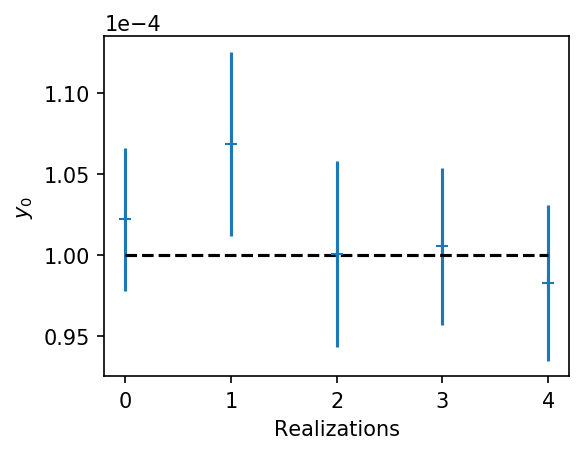

In [9]:
#visualize results

fig = plt.figure(figsize=(4,3), dpi=150)

plt.errorbar(np.arange(n_maps), results[0,:], yerr = results[1,:], fmt="+")
plt.plot([0,n_maps-1],[y_0,y_0], '--', color="black")
plt.xlabel("Realizations")
plt.ylabel(r"$y_0$")

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# Now follows the same examples but including a central point source for the cluster and using the constrained matched multifilter

We repeat the previous examples and combine the simulated cluster with Planck HFI foregrounds. In addition, we now add a central point source to the cluster to demonstrate the application of the constrained matched multifilter:

$\Psi(k) = e^\mathrm{T} S^{-1} P^{-1}(k) U(k)$,

with

$ S = \left[\int \mathrm{d}^2k \ U^\mathrm{T}(k) P^{-1}(k) U(k) \right]$,

$e = (1,0,\dots)$,

and

$  U(k)=\begin{pmatrix}
    F_1[1](k)  & F_2[1](k) & \dots & F_n[1](k)  \\
    \vdots      & \vdots       & \ddots& \vdots \\
    F_1[n_\nu](k) & F_2[n_\nu](k) & \dots & F_n[n_\nu](k) \\
    \end{pmatrix}.$

where $U$ is a matrix that contains the Fourier transform of the multi-frequency source templates that were convolved with the beam, $e$ is the response of the filter to the templates, and $P$ is the cross spectrum of the map. The function mf.filter_map_cmmf() requires three inputs, the first being a cube of the (mock) observations, the second, $U$, is a 4D array that contains the convolved source templates, and the third an array, $e$, that contains the filter responses. As before, in its default mode the function computes the cross spectrum directly from the provided data. The same optional variables as for the standard matched filter allow to provide either a separate noise map or the standard deviation of the noise in case it is Gaussian. As before, a global cross spectrum can be used or the cross-terms can be neglected entirely. The filter function returns three variables, the filtered map, the 2D filter window, and the noise of the filtered map

$\sigma = \left[\int \mathrm{d}^2k \ \Psi^\mathrm{T}(k) P(k) \Psi(k) \right]^\frac{1}{2}$.

In [10]:
data = np.zeros((nf,npix,npix)) #note dimensions
for i in np.arange(nf):
    #convolve mock data with beam
    data[i,:,:] = gaussian_filter(spec[i]*cluster, sigma=sigma_beam[i], order=0, mode='wrap', truncate=20.0)
    #add Planck HFI foregrounds
    data[i,:,:] += foregrounds[0,i,:,:]
    #add central point source
    data[i,:,:] += ps_sed[i]*point_source[i,:,:]
    #subtract mean of the maps
    data[i,:,:] -= np.mean(data[i,:,:])

#combine source templates into one array
templates = np.array([source, point_source]) #note dimensions

#define filter response
seds = np.array([spec, ps_sed]) #note dimensions

#define filter response
response = np.array([1,0]) #note dimensions

#filter data with matched filter
mmf_map, mmf_filter, mmf_noise = mf.filter_map_mmf(data, source, spec, global_cross=True)
#filter data with constrained matched filter
cmmf_map, cmmf_filter,cmmf_noise = mf.filter_map_cmmf(data, templates, seds, response, global_cross=True)

In [11]:
print("MF y_0: ", '{:0.2e}'.format(mmf_map[center]))
print("MF noise: ", '{:0.2e}'.format(mmf_noise))
print("MF SNR: ", '{:0.2f}'.format(mmf_map[center]/mmf_noise))
print("bias: ", '{:0.2f}'.format((mmf_map[center]-1e-4)/mmf_noise), "sigma")
print("")
print("CMF y_0: ", '{:06.2e}'.format(cmmf_map[center]))
print("CMF noise: ", '{:0.2e}'.format(cmmf_noise))
print("CMF SNR: ", '{:0.2f}'.format(cmmf_map[center]/cmmf_noise))
print("bias: ", '{:0.2f}'.format((cmmf_map[center]-1e-4)/cmmf_noise), "sigma")
print("")
print("sigma_CMF/sigma_MF: ", '{:0.2f}'.format(cmmf_noise/mmf_noise))

MF y_0:  -1.55e-04
MF noise:  4.43e-06
MF SNR:  -34.92
bias:  -57.49 sigma

CMF y_0:  1.03e-04
CMF noise:  4.95e-06
CMF SNR:  20.81
bias:  0.60 sigma

sigma_CMF/sigma_MF:  1.12


The three plots below show the mock data and the filtered maps. The latter two have been converted from $T_\mathrm{SZ}$ to $y_0$.

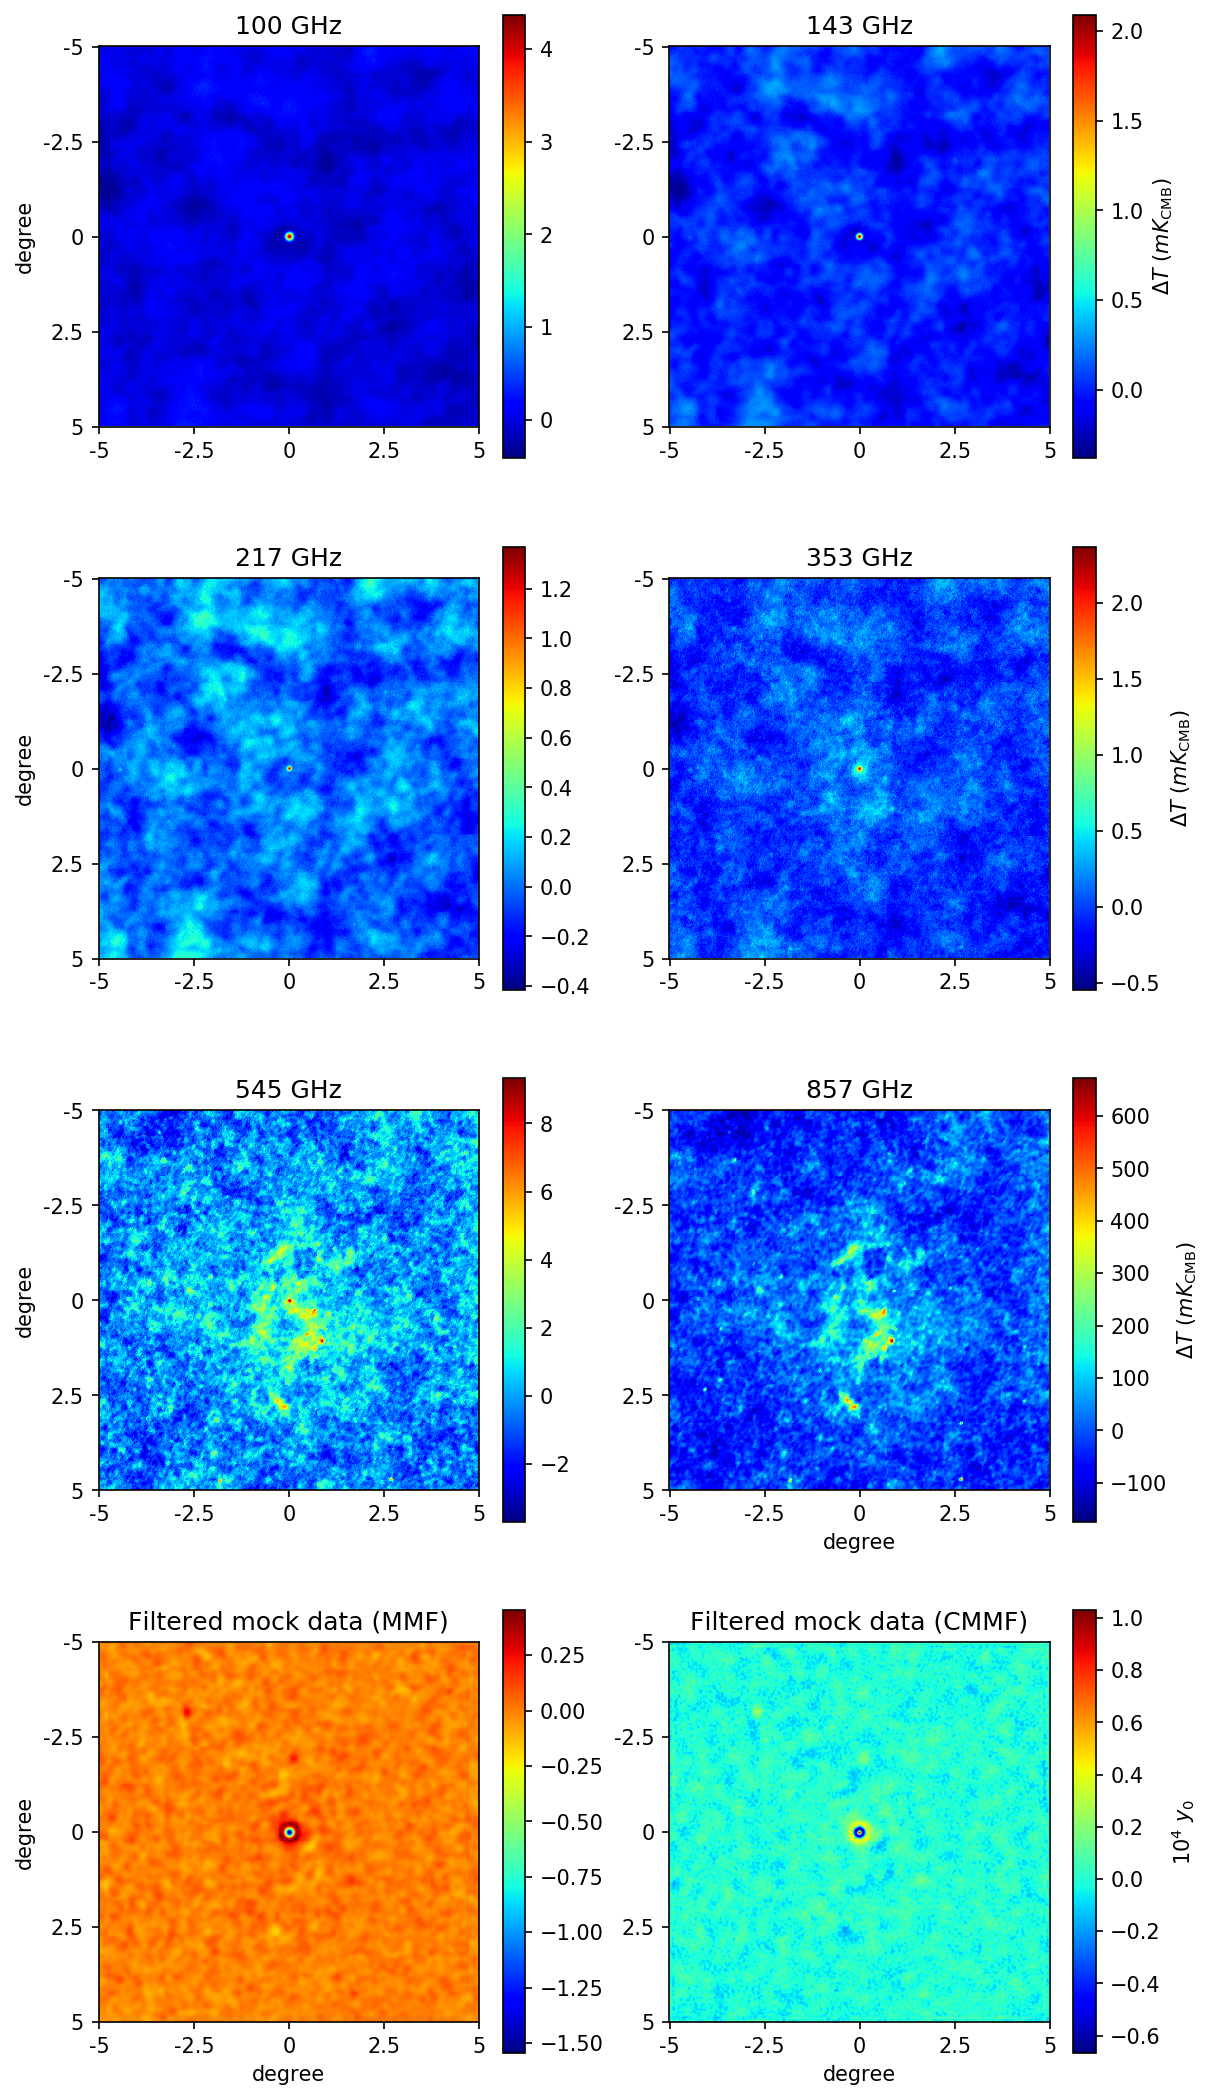

In [12]:
fig = plt.figure(figsize=(9,18), dpi=150)

plt.subplot(4,2,1)
plt.imshow(1e3*data[0,:,:], cmap = "jet")
plt.title("100 GHz")
plt.ylabel("degree")
plt.xticks([0,100,200,300,400],[-5,-2.5,0,2.5,5])
plt.yticks([0,100,200,300,400],[-5,-2.5,0,2.5,5])
plt.colorbar()

plt.subplot(4,2,2)
plt.imshow(1e3*data[1,:,:], cmap = "jet")
plt.title("143 GHz")
plt.xticks([0,100,200,300,400],[-5,-2.5,0,2.5,5])
plt.yticks([0,100,200,300,400],[-5,-2.5,0,2.5,5])
plt.colorbar(label = r"$\Delta T$ ($m K_\mathrm{CMB}$)")

plt.subplot(4,2,3)
plt.imshow(1e3*data[2,:,:], cmap = "jet")
plt.title("217 GHz")
plt.ylabel("degree")
plt.xticks([0,100,200,300,400],[-5,-2.5,0,2.5,5])
plt.yticks([0,100,200,300,400],[-5,-2.5,0,2.5,5])
plt.colorbar()

plt.subplot(4,2,4)
plt.imshow(1e3*data[3,:,:], cmap = "jet")
plt.title("353 GHz")
plt.xticks([0,100,200,300,400],[-5,-2.5,0,2.5,5])
plt.yticks([0,100,200,300,400],[-5,-2.5,0,2.5,5])
plt.colorbar(label = r"$\Delta T$ ($m K_\mathrm{CMB}$)")

plt.subplot(4,2,5)
plt.imshow(1e3*data[4,:,:], cmap = "jet")
plt.title("545 GHz")
plt.ylabel("degree")
plt.xticks([0,100,200,300,400],[-5,-2.5,0,2.5,5])
plt.yticks([0,100,200,300,400],[-5,-2.5,0,2.5,5])
plt.colorbar()

plt.subplot(4,2,6)
plt.imshow(1e3*data[5,:,:], cmap = "jet")
plt.title("857 GHz")
plt.xlabel("degree")
plt.xticks([0,100,200,300,400],[-5,-2.5,0,2.5,5])
plt.yticks([0,100,200,300,400],[-5,-2.5,0,2.5,5])
plt.colorbar(label = r"$\Delta T$ ($m K_\mathrm{CMB}$)")

plt.subplot(4,2,7)

plt.imshow(1e4*mmf_map, cmap = "jet")
plt.title("Filtered mock data (MMF)")
plt.xlabel("degree")
plt.ylabel("degree")
plt.xticks([0,100,200,300,400],[-5,-2.5,0,2.5,5])
plt.yticks([0,100,200,300,400],[-5,-2.5,0,2.5,5])
plt.colorbar()

plt.subplot(4,2,8)

plt.imshow(1e4*cmmf_map, cmap = "jet")
plt.title("Filtered mock data (CMMF)")
plt.xlabel("degree")
plt.xticks([0,100,200,300,400],[-5,-2.5,0,2.5,5])
plt.yticks([0,100,200,300,400],[-5,-2.5,0,2.5,5])
plt.colorbar(label = r"$10^4 \ y_0$")

The next figures show the 1D profiles of the filter windows and filter kernels. The frequency can be changed by changing the value of $i$.

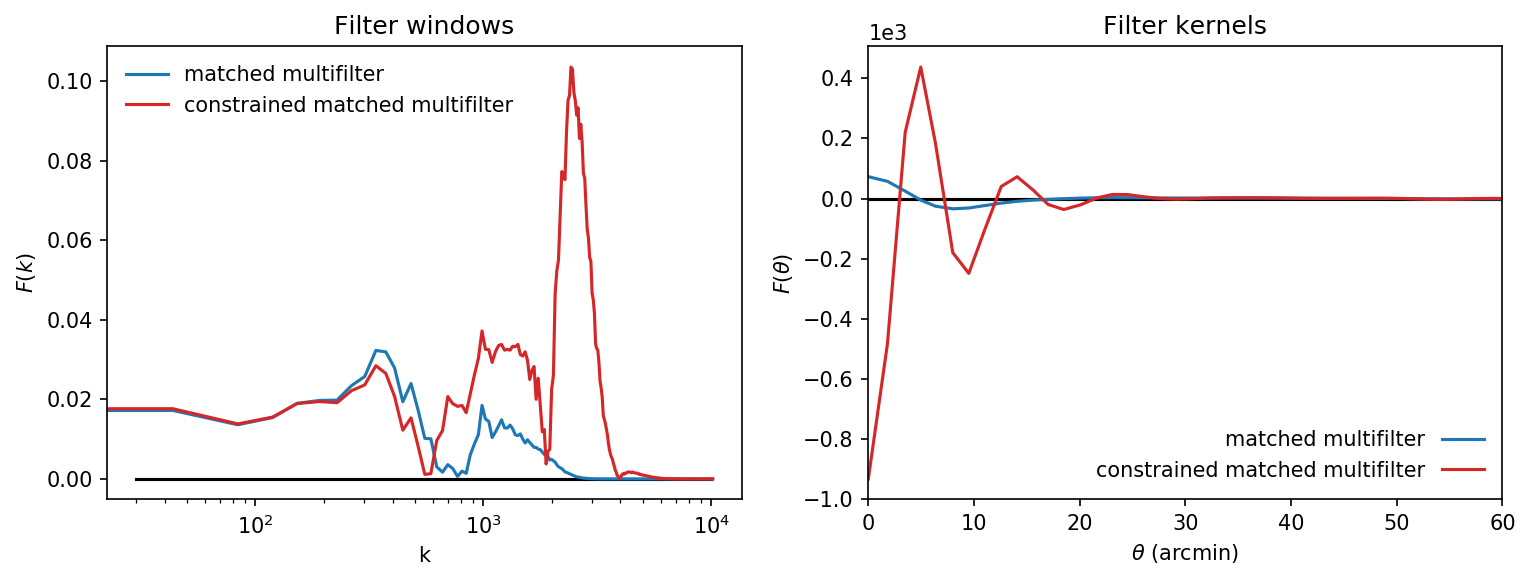

In [13]:
#Compute filter kernel through Fourier transform of the filter window
mmf_kernel = np.zeros((nf,npix,npix))
cmmf_kernel = np.zeros((nf,npix,npix))
for i in np.arange(nf):
    mmf_kernel[i,:,:] = np.real(np.fft.ifft2(np.fft.ifftshift(mmf_filter[i,:,:]))) * npix**2
    cmmf_kernel[i,:,:] = np.real(np.fft.ifft2(np.fft.ifftshift(cmmf_filter[i,:,:]))) * npix**2


i = 0 #change to plot different frequencies    
    
#Compute radial profiles of window and kernel. 
#The spatial frequency k has been computed using a conversion that allows a direct 
#comparison with the spherical multipole moment ell.
k, mmf_window = mf.rad_profile(np.abs(mmf_filter[i,:,:]), pixel_size, return_k=True)
k, cmmf_window = mf.rad_profile(np.abs(cmmf_filter[i,:,:]), pixel_size, return_k=True)
theta, mmf_kernel = mf.rad_profile(mmf_kernel[i,:,:], pixel_size, return_k=False) 
theta, cmmf_kernel = mf.rad_profile(cmmf_kernel[i,:,:], pixel_size, return_k=False)    

fig = plt.figure(figsize=(12,4), dpi=150)

plt.subplot(1,2,1)
plt.plot([3e1,1e4],[0,0], '-', color="black")
plt.semilogx(k, mmf_window, label="matched multifilter")
plt.semilogx(k, cmmf_window, color = "C3", label="constrained matched multifilter")
plt.title("Filter windows")
plt.xlabel(r"k")
plt.ylabel(r"$F(k)$")
plt.legend(frameon=False, loc="upper left", markerfirst=True)

plt.subplot(1,2,2)
plt.plot([0,170],[0,0], '-', color="black")
plt.plot(theta*pixel_size, mmf_kernel, label="matched multifilter")
plt.plot(theta*pixel_size, cmmf_kernel, color = "C3", label="constrained matched multifilter")
plt.xlim(0,60)
plt.title("Filter kernels")
plt.xlabel(r"$\theta$ (arcmin)")
plt.ylabel(r"$F(\theta)$")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend(frameon=False, loc="lower right", markerfirst=False)

Finally, we demonstrate that the central point source induces a bias in the matched multifiltered-map, while the constrained matched multifiltered-map is unbiased. For this we process 5 mock observations and plot the recovered $y_0$ value.

In [14]:
#This part of the code will create 100 mock-observations and filter the data

results = np.zeros((4,n_maps))

#initailize progress bar (optional)
f = FloatProgress(min=0, max=n_maps)
display(f)

for i in np.arange(n_maps):
    data = np.zeros((nf,npix,npix))
    for j in np.arange(nf):
        #convolve mock data with beam
        data[j,:,:] = gaussian_filter(spec[j]*cluster, sigma=sigma_beam[j], order=0, mode='wrap', truncate=20.0)
        #add Planck HFI foregrounds
        data[j,:,:] += foregrounds[i,j,:,:]   
        #add central point source
        data[j,:,:] += ps_sed[j]*point_source[j,:,:]
        #subtract mean of the maps
        data[j,:,:] -= np.mean(data[j,:,:])


    #filter data with matched filter
    mmf_map, mmf_filter, mmf_noise = mf.filter_map_mmf(data, source, spec, global_cross = True)
    #filter data with constrained matched filter
    cmmf_map, cmmf_filter,cmmf_noise = mf.filter_map_cmmf(data, templates, seds, response, global_cross = True)
    results[:,i] = [mmf_map[center], mmf_noise, cmmf_map[center], cmmf_noise]

    #increase value of progress bar (optional)
    f.value += 1

FloatProgress(value=0.0, max=5.0)

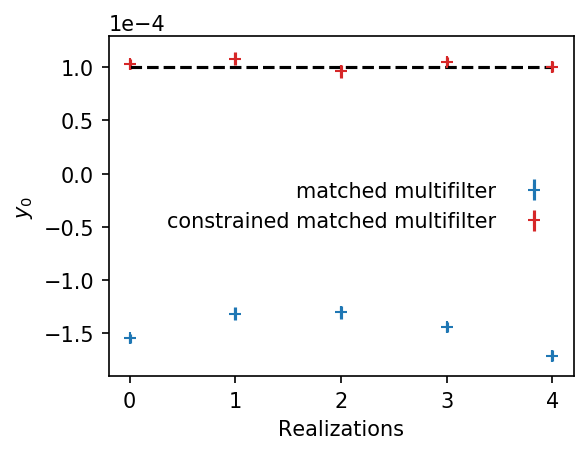

In [15]:
#visualize results

fig = plt.figure(figsize=(4,3), dpi=150)

plt.errorbar(np.arange(n_maps), results[0,:], yerr = results[1,:], fmt="+", label="matched multifilter")
plt.errorbar(np.arange(n_maps), results[2,:], yerr = results[3,:], fmt="+", color="C3", label="constrained matched multifilter")
plt.plot([0,n_maps-1],[y_0,y_0], '--', color="black")
plt.xlabel("Realizations")
plt.ylabel(r"$y_0$")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend(frameon=False, loc="center right", markerfirst=False)